# Llama-3.2-11B-Vision-Instruct

https://huggingface.co/meta-llama/Llama-3.2-11B-Vision-Instruct

In [2]:
# 필요한 라이브러리 설치 (transformers, accelerate, hf-transfer, huggingface-hub, gdown 등)
%pip install -Uq transformers accelerate hf-transfer huggingface-hub gdown


Note: you may need to restart the kernel to use updated packages.


In [2]:
import os # 운영체제와 상호작용하기 위한 os 모듈 임포트
# Hugging Face 토큰을 환경 변수에 설정하여 모델 다운로드 시 인증을 위한 절차
os.environ['HF_TOKEN'] = "YOUR_HF_TOKEN_HERE"


In [3]:
# 설치된 pillow 라이브러리의 상세 정보(버전, 경로 등) 확인
%pip show pillow


Name: pillow
Version: 12.1.1
Summary: Python Imaging Library (fork)
Home-page: https://python-pillow.github.io
Author: 
Author-email: "Jeffrey A. Clark" <aclark@aclark.net>
License-Expression: MIT-CMU
Location: /Users/jy/SKN23/multimodal/multi_venv/lib/python3.12/site-packages
Requires: 
Required-by: matplotlib, tensorboard, torchvision, ultralytics
Note: you may need to restart the kernel to use updated packages.


## VQA 데이터 준비

In [ ]:
# Runpod용 패키지 인스톨 (Runpod 환경에서 실행할 경우 아래 주석들을 해제하여 사용)
# !apt-get update -y # 우분투 패키지 목록 업데이트
# !apt-get install -y unzip # unzip 유틸리티 설치 (추후 데이터 압축 해제용)


In [ ]:
# 구글 드라이브에서 데이터셋 압축 파일(New_sample.zip) 직접 다운로드
# 대상 URL: https://drive.google.com/file/d/1ANLYW5kDijsL8bFcaTX93pSo9ib1Vnri/view?usp=drive_link
!gdown 1ANLYW5kDijsL8bFcaTX93pSo9ib1Vnri -O New_sample.zip


Downloading...
From (original): https://drive.google.com/uc?id=1ANLYW5kDijsL8bFcaTX93pSo9ib1Vnri
From (redirected): https://drive.google.com/uc?id=1ANLYW5kDijsL8bFcaTX93pSo9ib1Vnri&confirm=t&uuid=83381ffa-daa1-453d-a6ad-c5c498ce781b
To: /Users/jy/SKN23/multimodal/03_vision_language_model/New_sample.zip
100%|████████████████████████████████████████| 518M/518M [00:56<00:00, 9.22MB/s]


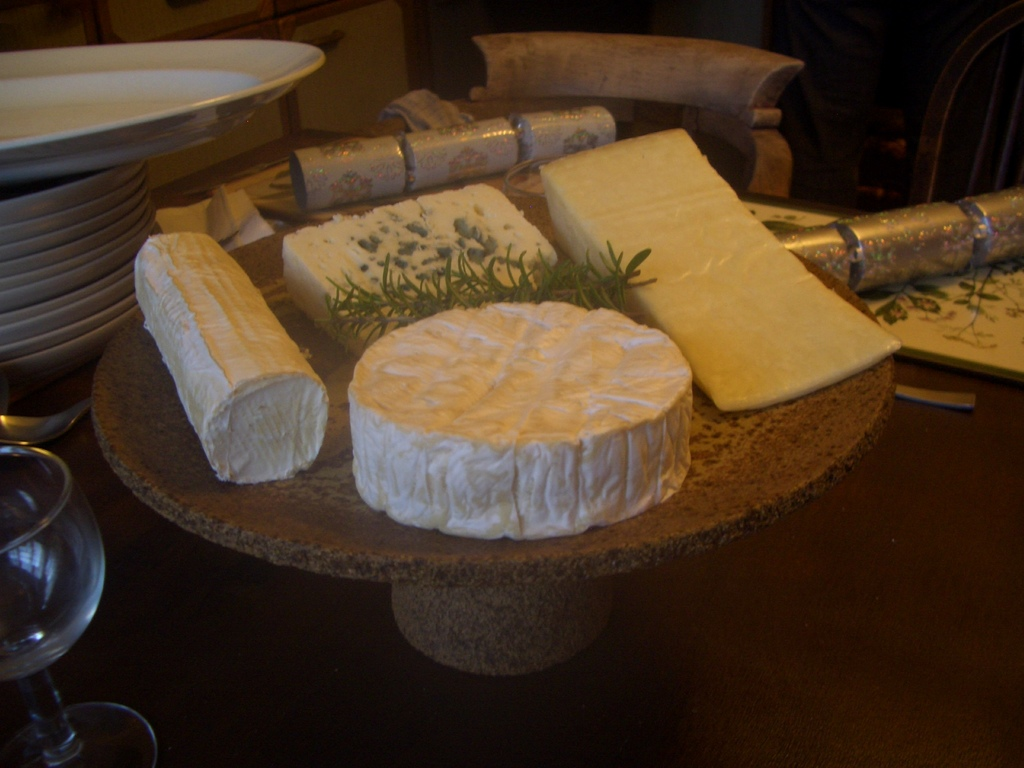

In [6]:
from PIL import Image # 이미지 처리를 위한 PIL(Python Imaging Library) 라이브러리에서 Image 모듈 임포트

# 로드할 이미지 파일의 절대 경로 지정
filename1 = "/Users/jy/SKN23/multimodal/03_vision_language_model/New_sample/원천데이터/food/중_train_food/NIA_dataset02_000000777750.jpg"
img1 = Image.open(filename1) # Image.open 함수를 사용해 지정한 경로의 이미지 객체 생성 및 로드
img1 # 쥬피터 노트북 환경 하단에 이미지를 출력하여 파일 확인


In [18]:
# 이미지 메타 데이터가 기록된 파일(images.json)을 로드하고 데이터 샘플 확인
import json # JSON 파일 파싱을 위한 기본 json 라이브러리 임포트

# 이미지 메타 데이터가 담긴 JSON 파일의 위치 경로 지정
images_json_filename1 = '/Users/jy/SKN23/multimodal/03_vision_language_model/New_sample/라벨링데이터/food/중_train_food/images.json'

# 지정된 JSON 파일을 읽기 모드('r')로 열어서 데이터 로드 (utf-8 인코딩 사용 지정)
with open(images_json_filename1, 'r', encoding='utf-8') as f:
    images_json_data = json.load(f) # JSON 파일 구조를 파이썬 딕셔너리로 변환하여 변수에 할당

# 파싱된 전체 데이터 구조 중 'images' 키에 해당하는 정보(이미지 목록 리스트) 추출
images_data = images_json_data['images']
print(len(images_data)) # 데이터셋에 포함된 전체 이미지의 총 개수 확인 및 출력
print(images_data[0]['image_id']) # 첫 번째 이미지 데이터의 고유 ID 식별자 출력
print(images_data[0]['image']) # 첫 번째 이미지의 실제 참조용 파일명(이름) 출력
print(images_data[0]['category']) # 첫 번째 이미지의 소속 카테고리(분류) 이름 출력


15921
1-1
NIA_dataset01_000000000001.jpg
food


In [21]:
# images.json 데이터에서 실제 파일명으로 고유 image_id를 찾는 함수 구현
import os # 운영체제 파일 경로 처리를 위한 os 모듈 임포트

# 문자열로 된 전체 파일 경로에서 마지막 파일명(basename) 부분만 추출하여 반환하는 함수
def get_filename_only(image_filepath):
    return os.path.basename(image_filepath)

# images.json의 데이터 딕셔너리에서 특정 파일명(filename)을 검색하여 해당하는 image_id를 찾아내는 함수
def get_image_id_by_filename(data, filename):
    for image_info in data.get('images', []):       # 데이터 내 'images' 리스트의 모든 요소를 반복 순회
        if image_info.get('image') == filename:     # 각 요소의 파일명('image')이 찾으려는 파일명 인자와 일치하는 경우
            return image_info.get('image_id')       # 바로 해당 이미지 객체의 고유 'image_id' 속성 값을 반환
    return None # 전체 루프가 종료될 때까지 일치하는 파일명을 찾지 못한 경우 None 반환

# 위에서 작성한 두 가지 함수들을 조합하여 원본 이미지 파일 경로(filename1)로부터 최종 이미지 ID 반환 및 출력
get_image_id_by_filename(images_json_data, get_filename_only(filename1))


'2-777750'

In [ ]:
# JSON 라이브러리 임포트 (JSON 형식 데이터를 파일에서 읽기 위함)
import json 

# 질문(question) 데이터 메타데이터가 포함된 세부 JSON 파일 경로 설정
question_json_filename1 = '/Users/jy/SKN23/multimodal/03_vision_language_model/New_sample/라벨링데이터/food/중_train_food/question.json'

# 설정된 JSON 파일을 안전하게 읽기 모드로 열어 데이터 로딩 (한글 처리를 위해 UTF-8 적용)
with open(question_json_filename1, 'r', encoding='utf-8') as f:
    question_json_data = json.load(f) # json.load를 이용해 파일 내용을 딕셔너리 포맷으로 변환

# 'questions' 키에 해당하는 정보(질문과 답변 관련 리스트 구조)만을 추출하여 저장
questions_data = question_json_data['questions']

# 현재 질문 세트 리스트 내의 전체 질문 데이터 개수 확인 및 출력
print(f"전체 질문 개수: {len(questions_data)}")

# 첫 번째 질문 항목(인덱스 0)을 리스트에서 선택하여 해당 질문의 고유 ID 정보 출력
print(f"질문 ID: {questions_data[0]['question_id']}")
# 질문과 매칭되는 참조 대상 이미지의 고유 ID 정보 출력
print(f"이미지 ID: {questions_data[0]['image_id']}")
# 첫 번째 질문의 실제 물음(사용자 질문의 내용) 텍스트 데이터 출력
print(f"질문 내용: {questions_data[0]['question']}")


전체 질문 개수: 81527
질문 ID: 1000
이미지 ID: 1-1
질문 내용: 분홍색 통은 몇 개입니까?


In [ ]:
# 전체 질문 데이터셋에서 특정 타깃 이미지 ID(image_id)와 연관된 개별 질문들만 모아서 반환하는 필터링 유틸리티 함수
def get_questions_by_image_id(data, image_id):
    # JSON 전체 데이터 딕셔너리에서 'questions' 리스트만 가져오고, 없으면 기본값인 빈 리스트([]) 반환
    questions = data.get('questions', []) 
    # image_id 속성값이 인자로 전달받은 대상 image_id와 동일한 질문 요소들만 조건 필터링하고,
    # 모델에 제공할 주요 필드(질문 ID와 질문 내용)만 따로 추출하여 새 리스트 컴프리헨션을 통해 재구성
    questions = [{
        'question_id': q['question_id'], # 각 필터링된 질문의 고유 question_id 값을 새 구조에 복사
        'question' : q['question']       # 각 필터링된 질문의 실제 문자열 question 값을 새 구조에 복사
    } for q in questions if q.get('image_id') == image_id]
    return questions # 필터링 과정을 거쳐 연관성이 있는 질문만 포함된 리스트를 반환

# 앞서 생성해두었던 파일 이름 기반에서 이미지 ID를 참조하는 함수들을 활용하여 변수 image_id1을 할당
image_id1 = get_image_id_by_filename(images_json_data, get_filename_only(filename1))
# 방금 얻어낸 특정 파일의 이미지 ID(image_id1)를 인자로 사용하여, 이 대상 이미지에 연관된 모든 VQA용 질문 목록을 JSON 데이터에서 검색
get_questions_by_image_id(question_json_data, image_id1)


[{'question_id': '777750001', 'question': '접시에 담겨 있는 것은 무엇입니까?'},
 {'question_id': '777750002', 'question': '테이블 왼쪽에 접시가 쌓여 있습니까?'},
 {'question_id': '777750003', 'question': '접시 위에 녹색 야채는 무엇입니까?'},
 {'question_id': '777750004', 'question': '테이블 위에 유리잔이 있습니까?'},
 {'question_id': '777750005', 'question': '접시 위에 원형 치즈가 있습니까?'}]